# Data Understanding
Dataset ini, yang berjudul "Best Books of the Decade: 2020's", bersumber dari Kaggle dan disediakan oleh Vala Khorasani.

Dataset ini terbagi menjadi dua bagian utama:

1.  **Best Books of the Decade: 2020s**: Bagian ini merupakan kumpulan data dari 2.327 buku terbaik yang diterbitkan selama dekade 2020-an. Pemilihan buku didasarkan pada peringkat (rating) pengguna dan popularitasnya. Informasi yang tersedia untuk setiap buku meliputi:
    *   `Index`: Pengenal unik untuk setiap buku.
    *   `Book Name`: Judul buku.
    *   `Author`: Nama penulis buku.
    *   `Rating`: Rata-rata peringkat yang diberikan oleh pengguna (dalam skala 1 hingga 5).
    *   `Number of Votes`: Jumlah total suara atau ulasan yang diterima buku tersebut.
    *   `Score`: Skor agregat yang dihitung berdasarkan kombinasi peringkat dan jumlah suara.

2.  **User Reviews**: Bagian kedua ini berisi data ulasan yang dibuat oleh pengguna, dengan total mencapai 600.000 ulasan. Data ulasan ini sangat berguna untuk analisis preferensi pengguna dan pengembangan sistem rekomendasi berbasis collaborative filtering. Kolom yang tersedia dalam bagian ini adalah:
    *   `userId`: Pengenal unik untuk setiap pengguna yang memberikan ulasan.
    *   `bookIndex`: Indeks buku yang merujuk pada `Index` di bagian pertama dataset, menghubungkan ulasan dengan buku spesifik.
    *   `score`: Skor atau peringkat yang diberikan oleh pengguna untuk buku tersebut (dalam skala 1 hingga 5).


## Import Library

In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, Flatten, Dense, Concatenate, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.metrics import RootMeanSquaredError
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity, euclidean_distances
from sklearn.decomposition import TruncatedSVD
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.neighbors import NearestNeighbors
from sklearn.cluster import KMeans
from scipy.sparse import csr_matrix
import matplotlib.pyplot as plt
import seaborn as sns

## Data Load

In [2]:
url_book  = "https://raw.githubusercontent.com/Rypper370/Recommendation-system/refs/heads/main/dataset/books_of_the_decade.csv"
url_user  = "https://raw.githubusercontent.com/Rypper370/Recommendation-system/refs/heads/main/dataset/user_reviews_dataset.csv"
book_df = pd.read_csv(url_book)
user_df = pd.read_csv(url_user)

In [3]:
# informasi data buku
book_df.info()
print(f"\nMengecek Missing Value : \n{book_df.isnull().sum()}")
print(f"\nMengecek Duplicate : {book_df.duplicated().sum()}")
print(f"\nMengecek nilai unique : \n{book_df.nunique()}")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2329 entries, 0 to 2328
Data columns (total 6 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   Index            2329 non-null   int64 
 1   Book Name        2329 non-null   object
 2   Author           2329 non-null   object
 3   Rating           2329 non-null   object
 4   Number of Votes  2329 non-null   object
 5   Score            2329 non-null   int64 
dtypes: int64(2), object(4)
memory usage: 109.3+ KB

Mengecek Missing Value : 
Index              0
Book Name          0
Author             0
Rating             0
Number of Votes    0
Score              0
dtype: int64

Mengecek Duplicate : 0

Mengecek nilai unique : 
Index              2329
Book Name          2327
Author             1768
Rating              176
Number of Votes    2212
Score               634
dtype: int64


Berdasarkan informasi analisis diatas, dataset `book_df` berisi **2329** buku dengan 6 kolom data (**Index**, **Book Name**, **Author**, **Rating**, **Number of Votes**, **Score**). Dataset ini sangat bersih karena tidak ada missing values sama sekali di semua kolom. Terdapat variasi yang baik dalam data dengan **2327** judul buku unik, **1768** penulis unik, dan **176** rating berbeda. Kolom **Number of Votes** memiliki **2212** nilai unik dan **Score** memiliki **634** nilai unik, menunjukkan distribusi data yang beragam.

In [4]:
# informasi data user
user_df.info()
print(f"\nMengecek Missing Value : \n{user_df.isnull().sum()}")
print(f"\nMengecek Duplicate : {user_df.duplicated().sum()}")
print(f"\nMengecek nilai unique : \n{user_df.nunique()}")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 600000 entries, 0 to 599999
Data columns (total 3 columns):
 #   Column     Non-Null Count   Dtype
---  ------     --------------   -----
 0   userId     600000 non-null  int64
 1   bookIndex  600000 non-null  int64
 2   score      600000 non-null  int64
dtypes: int64(3)
memory usage: 13.7 MB

Mengecek Missing Value : 
userId       0
bookIndex    0
score        0
dtype: int64

Mengecek Duplicate : 175

Mengecek nilai unique : 
userId       79957
bookIndex     2327
score            5
dtype: int64


Berdasarkan informasi diatas, data ini berisi **600.000** entri dengan 3 kolom data **(userId, bookIndex, score)** yang semuanya bertipe integer. Dataset ini sangat bersih karena tidak ada missing values sama sekali di semua kolom. Terdapat **79.957 pengguna unik**, **2.327 buku unik**, namun hanya **5 nilai score** unik yang menunjukkan sistem rating terbatas. Dataset memiliki **175 baris duplikat** yang perlu diperhatikan untuk analisis lebih lanjut.

## Visualisasi data

<ipython-input-5-68cf3e508e06>:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Rating', y='Book Name', data=top_10_books, palette='viridis')


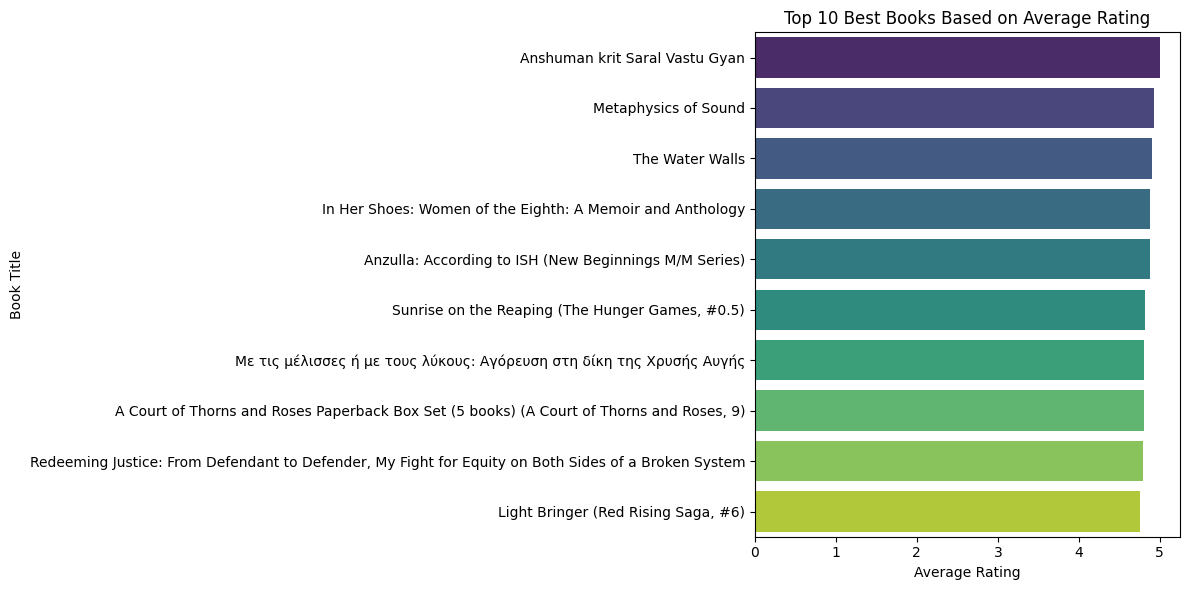

In [5]:
# Visualisasi 10 buku terbaik berdasarkan rating
book_df['Rating'] = pd.to_numeric(book_df['Rating'], errors='coerce')

book_ratings = book_df.groupby('Book Name')['Rating'].mean().reset_index()
top_rated_books = pd.merge(book_ratings, book_df[['Book Name', 'Author']], on='Book Name')
top_10_books = top_rated_books.sort_values(by='Rating', ascending=False).head(10)

plt.figure(figsize=(12, 6))
sns.barplot(x='Rating', y='Book Name', data=top_10_books, palette='viridis')
plt.title('Top 10 Best Books Based on Average Rating')
plt.xlabel('Average Rating')
plt.ylabel('Book Title')
plt.tight_layout()
plt.show()

Berdasarkan hasil analisis grafik diatas, menampilkan 10 buku dengan rating tertinggi berdasarkan rata-rata penilaian pengguna dalam dataset sistem rekomendasi. Buku **Anshuman krit Saral Vastu Gyan** dan **Metaphysics of Sound** menduduki peringkat teratas dengan rating mendekati **5.0**, menunjukkan kepuasan pengguna yang sangat tinggi terhadap kedua buku tersebut. Sebagian besar buku dalam daftar ini memiliki rating di atas **4.5**, yang mengindikasikan kualitas konten yang baik dan respon positif dari pembaca. Informasi ini memberikan gambaran tentang preferensi umum pengguna dan dapat menjadi acuan untuk memahami jenis buku apa yang cenderung mendapat apresiasi tinggi dalam dataset ini.

<ipython-input-6-8b401acf418c>:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Rating', y='Author', data=top_10_author, palette='viridis')


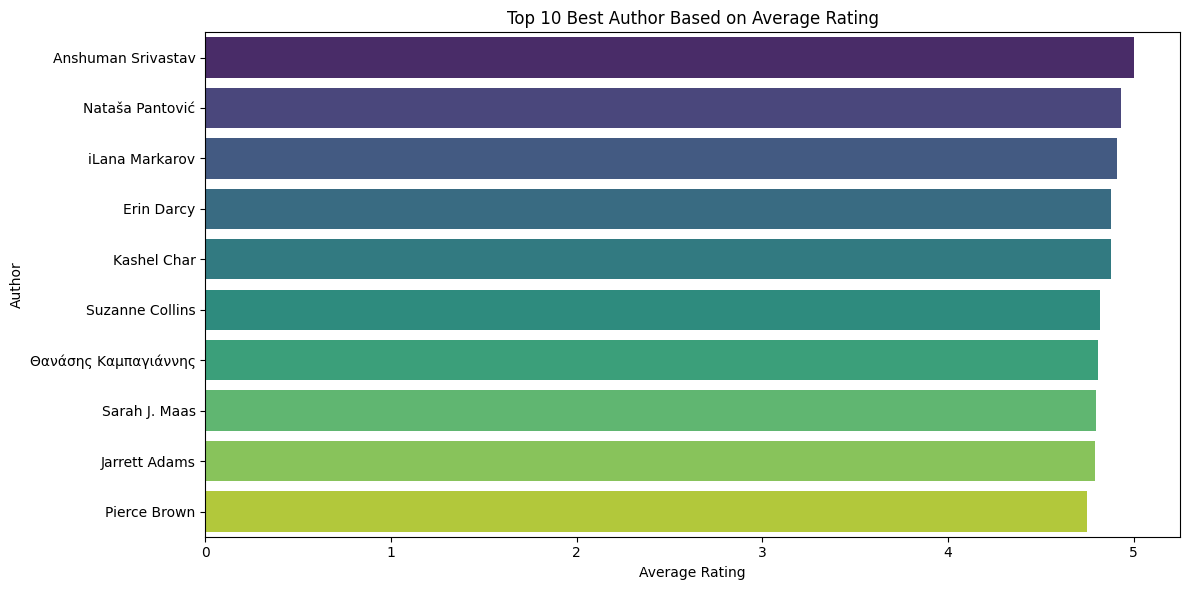

In [6]:
# Visualisasi 10 penulis berdasarkan rata-rata rating
author_ratings = book_df.groupby('Author')['Rating'].mean().reset_index()
top_rated_author = pd.merge(author_ratings, book_df[['Book Name', 'Author']], on='Author')
top_10_author = top_rated_books.sort_values(by='Rating', ascending=False).head(10)

plt.figure(figsize=(12, 6))
sns.barplot(x='Rating', y='Author', data=top_10_author, palette='viridis')
plt.title('Top 10 Best Author Based on Average Rating')
plt.xlabel('Average Rating')
plt.ylabel('Author')
plt.tight_layout()
plt.show()

Berdasarkan hasil analisis grafik diatas, menampilkan 10 penulis dengan rating tertinggi berdasarkan rata-rata penilaian dari semua buku yang mereka tulis dalam dataset sistem rekomendasi. **Anshuman Srivastav** dan **Nataša Pantović** menduduki peringkat teratas dengan rating mendekati **5.0**, menunjukkan bahwa karya-karya mereka secara konsisten mendapat apresiasi tinggi dari pembaca. Sebagian besar penulis dalam daftar ini memiliki rating di atas **4.5**, yang mengindikasikan kualitas tulisan yang baik dan kemampuan mereka dalam menciptakan konten yang memuaskan pembaca.

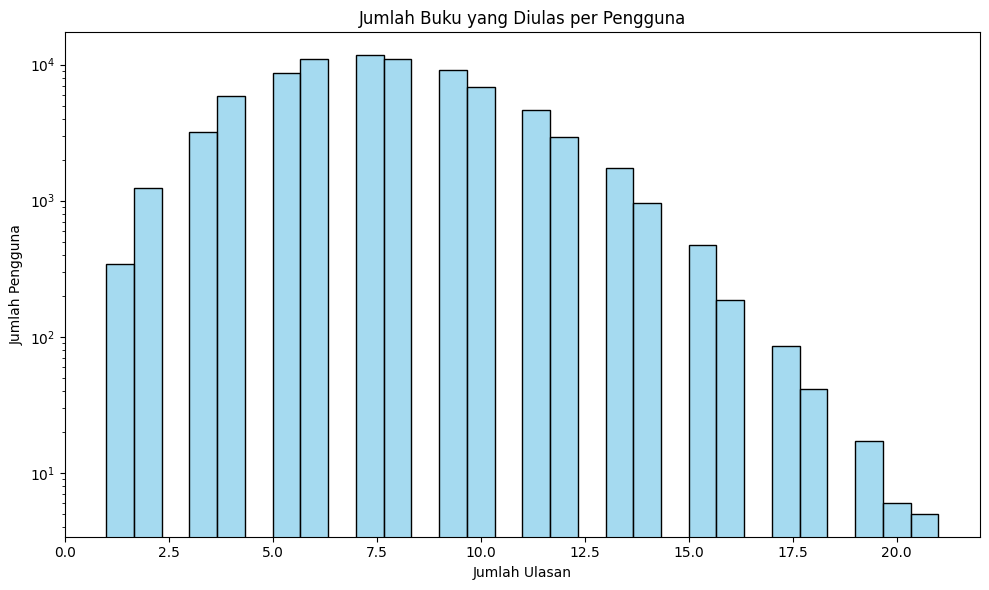

In [7]:
# Visualisasi jumlah buku yang diulas per pengguna
user_reviews = user_df["userId"].value_counts()
plt.figure(figsize=(10, 6))
sns.histplot(user_reviews, bins=30, color="skyblue")
plt.title("Jumlah Buku yang Diulas per Pengguna")
plt.xlabel("Jumlah Ulasan")
plt.ylabel("Jumlah Pengguna")
plt.yscale("log")
plt.tight_layout()
plt.show()

Berdasarkan hasil analisis grafik diatas, menampilkan distribusi jumlah buku yang diulas per pengguna dalam dataset sistem rekomendasi, dengan menggunakan skala logaritmik pada sumbu y untuk mengakomodasi rentang data yang luas. Sebagian besar pengguna memberikan ulasan untuk **6-8 buku**, yang ditunjukkan dengan puncak distribusi pada rentang tersebut dengan jumlah pengguna mencapai lebih dari **10.000 orang**. Terdapat penurunan signifikan jumlah pengguna seiring dengan bertambahnya jumlah buku yang diulas, menunjukkan bahwa hanya sedikit pengguna yang sangat aktif dalam memberikan banyak ulasan. Distribution ini mencerminkan pola umum dalam platform review dimana mayoritas pengguna bersifat casual dengan aktivitas terbatas, sementara pengguna yang memberikan **15+ ulasan** sangat sedikit jumlahnya. Pada ujung ekstrim, terdapat pengguna yang memberikan hingga **20+ ulasan** dengan jumlah yang sangat kecil (di bawah 10 pengguna).

In [8]:
score_distribution =  user_df["score"].value_counts().sort_index()
print(f"Score Distribution masing-masing rating : \n{score_distribution}")

Score Distribution masing-masing rating : 
score
1    120534
2    120139
3    119543
4    119524
5    120260
Name: count, dtype: int64


<ipython-input-9-d760f8d40d2e>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=score_distribution.index, y=score_distribution.values, palette="Oranges_r")


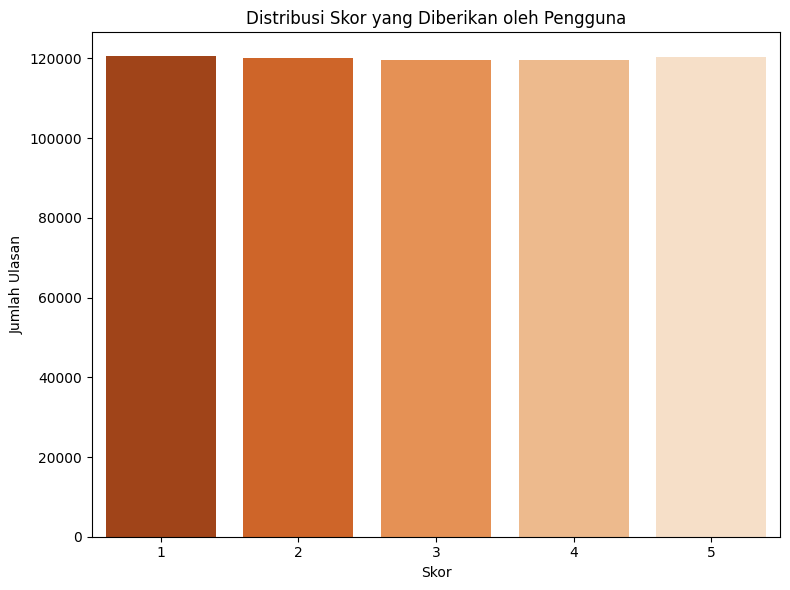

In [9]:
# Visualisasi Skor yang diberikan oleh pengguna
plt.figure(figsize=(8, 6))
sns.barplot(x=score_distribution.index, y=score_distribution.values, palette="Oranges_r")
plt.title("Distribusi Skor yang Diberikan oleh Pengguna")
plt.xlabel("Skor")
plt.ylabel("Jumlah Ulasan")
plt.tight_layout()
plt.show()

Berdasarkan hasil analisis grafik diatas, menampilkan bahwa pola penilaian menunjukkan sebaran yang relatif merata di seluruh kategori rating dari 1 hingga 5. **Rating 1 (sangat tidak puas)** memiliki **frekuensi tertinggi** dengan **120.498 ulasan**, menunjukkan adanya sejumlah besar pengguna yang memberikan penilaian **negatif**. **Rating 5 (sangat puas)** berada di posisi kedua dengan **120.223 ulasan**, diikuti oleh **rating 2** dengan **120.109 ulasan**, yang mengindikasikan polarisasi dalam kepuasan pengguna. **Rating 3 dan 4** memiliki frekuensi yang hampir sama dengan masing-masing **119.507** dan **119.488 ulasan**, menunjukkan konsistensi dalam penilaian **netral** hingga **positif**. Distribusi yang **seimbang** ini dengan variasi hanya sekitar **1.000 ulasan** antar kategori menunjukkan bahwa dataset ini cukup representatif dan tidak memiliki bias yang signifikan, sehingga dapat memberikan gambaran yang objektif tentang tingkat kepuasan pengguna secara keseluruhan.

# Data preparation


## Book_df

In [10]:
# Membersihkan data book_df
book_df["Rating"] = pd.to_numeric(book_df["Rating"], errors="coerce")
book_df = book_df.dropna(subset=["Rating", "Number of Votes"])
book_df['Rating'] = book_df['Rating'].astype(float)

# membuat fitur untuk model content-based filtering
book_df['features'] = book_df['Author'] + ' ' + book_df['Rating'].astype(str)
print(f"Dataset siap: {len(book_df)} buku")
print(f"Contoh features: '{book_df['features'].iloc[0]}'")

Dataset siap: 2305 buku
Contoh features: 'Victoria Schwab 4.18'


<ipython-input-10-0df9a4b790ea>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  book_df['Rating'] = book_df['Rating'].astype(float)
<ipython-input-10-0df9a4b790ea>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  book_df['features'] = book_df['Author'] + ' ' + book_df['Rating'].astype(str)


Melakukan pembersihan data untuk **book_df** sebelum digunakan untuk **model content-based filtering**. Pada kolom **Rating** diubah menjadi tipe numerik dan data yang tidak valid otomatis diubah menjadi **NaN**, kemudian baris-baris yang memiliki nilai kosong di kolom **Rating** atau **Number of Votes** dihapus untuk memastikan data yang digunakan lengkap. Setelah itu, kolom Rating dipastikan bertipe float untuk konsistensi perhitungan matematika. Terakhir, dibuat kolom baru bernama `features` yang menggabungkan nama Author dan Rating  yang nantinya akan digunakan untuk membangun **model content-based filtering** dalam sistem rekomendasi buku.

## User df

In [11]:
# Menghapus duplikasi pada data user_df
initial_rows = len(user_df)
user_df.drop_duplicates(inplace=True)
rows_removed = initial_rows - len(user_df)

print(f"Jumlah baris duplikat yang dihapus dari user_df: {rows_removed}")
print(f"Jumlah baris user_df setelah menghapus duplikat: {len(user_df)}")

Jumlah baris duplikat yang dihapus dari user_df: 175
Jumlah baris user_df setelah menghapus duplikat: 599825


Melakukan pembersihan missing value pada data **User df** yang ditemukan duplikasi data sebanyak 175 baris dari **600.000 baris**. Sehingga ketika dihapus menjadi **599.825 baris data**.

In [12]:
# Melakukan penggabungan data user_df dengan data book_df dengan mengambil kolom Book Name
merged_df = user_df.merge(book_df[['Index', 'Book Name']],
                         left_on='bookIndex',
                         right_on='Index',
                         how='left')

# menghapus kolom index untuk menghindari redudansi
merged_df = merged_df.drop('Index', axis=1)
print(f"\nDataset shape: {merged_df.shape}")
print("\nSample merged data:")
print(merged_df.head())


Dataset shape: (599825, 4)

Sample merged data:
   userId  bookIndex  score                                          Book Name
0   65674        745      3                                          Eden Mine
1   45825        454      1            A Stitch in Time (A Stitch in Time, #1)
2   22291       1523      3  The Unforgettable Logan Foster (Logan Foster, #1)
3   66943       1727      5                                        Age of Vice
4   27529       1867      2              Angelika Frankenstein Makes Her Match


 melakukan proses penggabungan **(merge)** antara data **user_df** dengan data **book_df** untuk mendapatkan informasi yang lebih lengkap. Penggabungan dilakukan dengan mengambil kolom `Index` dan `Book Name` dari **book_df**, lalu menggabungkannya dengan **user_df** berdasarkan kolom `bookIndex` di **user_df** dan kolom `Index` di **book_df** menggunakan **left join**. Setelah penggabungan selesai, kolom `Index` yang redundan (duplikat) dihapus dari dataset terbaru hasil merge untuk menghindari redudansi dan menjaga struktur data tetap bersih. Hasilnya adalah dataset baru **(merged_df)** yang berisi informasi user beserta nama buku yang dibaca, bukan hanya index bukunya saja.

In [13]:
# Melakukan Mapping user dan book ke indices
user_ids = merged_df['userId'].unique().tolist()
book_indices = merged_df['bookIndex'].unique().tolist()
user_to_index = {user_id: index for index, user_id in enumerate(user_ids)}
book_to_index = {book_index: index for index, book_index in enumerate(book_indices)}

# Melakukan reverse mapping untuk analisis nanti
index_to_user = {index: user_id for user_id, index in user_to_index.items()}
index_to_book = {index: book_index for book_index, index in book_to_index.items()}

# mapping
merged_df['userId_mapped'] = merged_df['userId'].map(user_to_index)
merged_df['bookIndex_mapped'] = merged_df['bookIndex'].map(book_to_index)

num_users = len(user_ids)
num_books = len(book_indices)
print(f"Total Users: {num_users}")
print(f"Total Books: {num_books}")
print(f"Total Interactions: {len(merged_df)}")

# Mengecek missing value
print(f"\nMissing userId mappings: {merged_df['userId_mapped'].isna().sum()}")
print(f"Missing bookIndex mappings: {merged_df['bookIndex_mapped'].isna().sum()}")

Total Users: 79957
Total Books: 2327
Total Interactions: 599825

Missing userId mappings: 0
Missing bookIndex mappings: 0


Pada tahap ini melakukan proses **mapping** atau pemetaan **userID** dan **bookIndex** menjadi indeks numerik secara berurutan untuk keperluan tahapan selanjutnya. Kemudian, diambil semua **userId** dan **bookIndex** yang unik dari dataset. Sehingga hasil mapping ini diterapkan ke dataset dengan membuat kolom baru **'userId_mapped'** dan **'bookIndex_mapped'** yang berisi indeks numerik berurutan. Berdasarkan hasil **mapping** yang diterapkan ke dataset dengan membuat kolom baru 'userId_mapped' dan 'bookIndex_mapped' yang berisi indeks numerik. Sehingga menghasilkan  **79.957 user unik**, **2.327 buku unik**, dengan total **599.825 interaksi**, dan semua data berhasil dipetakan tanpa ada nilai yang hilang.

In [14]:
# Menyusun data fitur dan target menggunakan mapped indices
x = merged_df[['userId_mapped', 'bookIndex_mapped']].values
y = merged_df['score'].values.astype('float32')

print(f"Feature matrix shape: {x.shape}")
print(f"Target vector shape: {y.shape}")

Feature matrix shape: (599825, 2)
Target vector shape: (599825,)


Kemudian melakukan tahapan untuk menyusun fitur input dan target output menggunakan hasil mapping yang telah dibuat sebelumnya, di mana kolom **userId_mapped** dan **bookIndex_mapped**  dijadikan sebagai fitur **input (X)**, sedangkan kolom 'score' dijadikan sebagai target yang akan **diprediksi (y)**. Sehingga menghasilkan **feature matrix** berukuran **(599825, 2)** dan  target vector berukuran **(599825,)** yang berisi **score** untuk setiap interaksi.

In [15]:
# Melakukan data splitting
x_train, x_val, y_train, y_val = train_test_split(x, y, test_size=0.2, random_state=42)

print(f"Training set: {x_train.shape[0]} samples")
print(f"Validation set: {x_val.shape[0]} samples")

# Normalisasi data rating
train_mean = np.mean(y_train)
train_std = np.std(y_train)

print(f"\nSebelum Normalisasi :")
print(f"  Mean: {train_mean:.4f}")
print(f"  Std: {train_std:.4f}")
print(f"  Min: {np.min(y_train):.4f}")
print(f"  Max: {np.max(y_train):.4f}")

# Normalisasi menggunakan statistik dari data training
y_train_norm = (y_train - train_mean) / train_std
y_val_norm = (y_val - train_mean) / train_std

print(f"\nSetelah normalization:")
print(f"  Training - Mean: {np.mean(y_train_norm):.4f}, Std: {np.std(y_train_norm):.4f}")
print(f"  Validation - Mean: {np.mean(y_val_norm):.4f}, Std: {np.std(y_val_norm):.4f}")

Training set: 479860 samples
Validation set: 119965 samples

Sebelum Normalisasi :
  Mean: 2.9978
  Std: 1.4160
  Min: 1.0000
  Max: 5.0000

Setelah normalization:
  Training - Mean: -0.0000, Std: 1.0000
  Validation - Mean: 0.0009, Std: 0.9994


Melakukan **data splitting (80% training, 20% validation)** dan normalisasi sebagai tahapan preprocessing akhir sebelum training. Splitting dilakukan terlebih dahulu untuk mencegah data leakage, dimana informasi validation set bisa "bocor" ke training jika normalisasi dilakukan sebelum splitting. Normalisasi dilakukan dengan menghitung **mean (2.9978)** dan **std (1.4160)** hanya dari data training.

# Modeling & Result

## Model Content Based Filtering

In [16]:
tfidf = TfidfVectorizer(stop_words='english', max_features=1000)
tfidf_matrix = tfidf.fit_transform(book_df['features'])
cosine_sim = cosine_similarity(tfidf_matrix)

def get_content_recommendations(book_index, num_rec=5):
    sim_scores = list(enumerate(cosine_sim[book_index]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    sim_scores = sim_scores[1:num_rec+1]

    # Mendapatkan buku dari indices dan similarity scores
    book_indices = [i[0] for i in sim_scores]
    similarities = [i[1] for i in sim_scores]

    #Membuat hasil dengan cosine similarity
    result = book_df.iloc[book_indices][['Book Name', 'Author', 'Rating']].copy()
    result['Cosine_Similarity'] = [f"{score:.4f}" for score in similarities]

    return result

test_book = 0
print(f"\n{'='*50}")
print(f"REKOMENDASI UNTUK BUKU INDEX {test_book}")
print(f"{'='*50}")

target_book = book_df.iloc[test_book]
print(f"Target Book: {target_book['Book Name']}")
print(f"Author: {target_book['Author']}")
print(f"Rating: {target_book['Rating']}")

print(f"\nTop 5 Recommendations:")
content_recs = get_content_recommendations(test_book)
print(content_recs.to_string(index=False))


REKOMENDASI UNTUK BUKU INDEX 0
Target Book: The Invisible Life of Addie LaRue
Author: Victoria Schwab
Rating: 4.18

Top 5 Recommendations:
                                          Book Name            Author  Rating Cosine_Similarity
The Fragile Threads of Power (Threads of Power, #1)   Victoria Schwab    4.30            0.8723
                Bridge of Souls (Cassidy Blake, #3)   Victoria Schwab    4.03            0.7668
                                            Gallant   Victoria Schwab    3.71            0.7518
                                              China Edward Rutherfurd    4.18            0.4890
                  Realm Breaker (Realm Breaker, #1)  Victoria Aveyard    3.59            0.4398


Berdasarkan hasil model **content-based filtering** diatas, dengan fokus utama pada kesamaan **author**. Dari 5 rekomendasi yang diberikan, 3 buku teratas semuanya merupakan karya **Victoria Schwab** (author yang sama dengan buku target), dengan nilai **cosine similarity** yang sangat tinggi berkisar antara **0.7518-0.8723**. Hal ini menunjukkan bahwa sistem memberikan bobot yang besar pada faktor kepengarangan dalam menghitung kesamaan antar buku. Model ini berasumsi bahwa pembaca yang menyukai satu karya dari seorang author akan cenderung menyukai karya lainnya dari author yang sama. Kemudian, rekomendasi terakhir dari author berbeda **Edward Rutherfurd dan Victoria Aveyard** yang  memiliki similarity score yang jauh lebih rendah **0.4398-0.4890**, menunjukkan bahwa tanpa kesamaan author, tingkat kesamaan menjadi berkurang signifikan. Dengan demikian, sistem rekomendasi ini sangat bergantung pada preferensi pembaca terhadap author tertentu sebagai prediktor utama untuk memberikan rekomendasi yang relevan.

## Model Collaborative Filtering

In [17]:
class SimpleCollaborativeFiltering:
    def __init__(self, num_users, num_books, embedding_dim=50):
        self.num_users = num_users
        self.num_books = num_books
        self.embedding_dim = embedding_dim
        self.model = None
        self.history = None
        self.train_mean = None
        self.train_std = None

    def build_model(self):
        #Membangun arsitektur model

        # Input layers
        user_input = Input(shape=(), name='user_id')
        book_input = Input(shape=(), name='book_id')

        # Embedding layers - mengubah ID menjadi vector
        user_embedding = Embedding(
            input_dim=self.num_users,
            output_dim=self.embedding_dim,
            name='user_embedding'
        )(user_input)

        book_embedding = Embedding(
            input_dim=self.num_books,
            output_dim=self.embedding_dim,
            name='book_embedding'
        )(book_input)

        # Flatten embedding menjadi 1D vector
        user_vec = Flatten()(user_embedding)
        book_vec = Flatten()(book_embedding)

        # Gabungkan user dan book vectors
        concat = Concatenate()([user_vec, book_vec])

        # Dense layers untuk pembelajaran pola yang lebih kompleks
        dense1 = Dense(128, activation='relu')(concat)
        dropout1 = Dropout(0.2)(dense1)

        dense2 = Dense(64, activation='relu')(dropout1)
        dropout2 = Dropout(0.2)(dense2)

        # Output layer - prediksi rating/score
        output = Dense(1, activation='linear')(dropout2)

        # Compile model
        model = Model(inputs=[user_input, book_input], outputs=output)
        model.compile(
            optimizer=Adam(learning_rate=0.001),
            loss='mean_squared_error',
            metrics=[RootMeanSquaredError(name='rmse'), 'mae']
        )

        self.model = model
        return model

    def train(self, x_train, y_train, x_val, y_val, epochs=100, batch_size=256, verbose=1):
        # Melatih model
        if self.model is None:
            self.build_model()
        callbacks = [
            EarlyStopping(
                monitor='val_rmse',
                patience=10,
                restore_best_weights=True
            ),
            ReduceLROnPlateau(
                monitor='val_rmse',
                factor=0.5,
                patience=5,
                min_lr=0.0001
            )
        ]

        # Training
        self.history = self.model.fit(
            [x_train[:, 0], x_train[:, 1]], y_train,
            validation_data=([x_val[:, 0], x_val[:, 1]], y_val),
            epochs=epochs,
            batch_size=batch_size,
            callbacks=callbacks,
            verbose=verbose
        )

        return self.history

    def predict(self, user_ids, book_ids):
        return self.model.predict([user_ids, book_ids])

    def denormalize_predictions(self, predictions):
        #Mengembalikan prediksi ke skala asli"
        if self.train_mean is not None and self.train_std is not None:
            return predictions * self.train_std + self.train_mean
        return predictions

print("Collaborative Filtering class defined successfully!")
print("=" * 60)
print("MODEL INITIALIZATION")
print("=" * 60)

# Inisialisasi model
cf_model = SimpleCollaborativeFiltering(
    num_users=num_users,
    num_books=num_books,
    embedding_dim=50
)

# Simpan statistik normalisasi untuk denormalisasi nanti
cf_model.train_mean = train_mean
cf_model.train_std = train_std

# Build model dan lihat arsitekturnya
model = cf_model.build_model()

print("Model berhasil diinisialisasi!")
print(f"Embedding dimension: {cf_model.embedding_dim}")
print(f"Total parameters: {model.count_params():,}")

print("\nArsitektur Model:")
model.summary()

Collaborative Filtering class defined successfully!
MODEL INITIALIZATION
Model berhasil diinisialisasi!
Embedding dimension: 50
Total parameters: 4,135,449

Arsitektur Model:


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ user_id             │ (None)            │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ book_id             │ (None)            │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ user_embedding      │ (None, 50)        │  3,997,850 │ user_id[0][0]     │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ book_embedding      │ (None, 50)        │    116,350 │ book_id[0][0]     │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten (Flatten)   │ (None, 50)        │          0 │ user_embedding[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_1 (Flatten) │ (None, 50)        │          0 │ book_embedding[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 100)       │          0 │ flatten[0][0],    │
│ (Concatenate)       │                   │            │ flatten_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 128)       │     12,928 │ concatenate[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 128)       │          0 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 64)        │      8,256 │ dropout[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 64)        │          0 │ dense_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 1)         │         65 │ dropout_1[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 4,135,449 (15.78 MB)

 Trainable params: 4,135,449 (15.78 MB)

 Non-trainable params: 0 (0.00 B)

In [18]:
print("Memulai training model...")
history = cf_model.train(
    x_train, y_train_norm,
    x_val, y_val_norm,
    epochs=10,
    batch_size=256,
    verbose=1
)

print(f"\nTraining selesai!")

Memulai training model...
Epoch 1/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 81s 41ms/step - loss: 0.9983 - mae: 0.8509 - rmse: 0.9991 - val_loss: 0.9989 - val_mae: 0.8501 - val_rmse: 0.9994 - learning_rate: 0.0010
Epoch 2/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 92s 47ms/step - loss: 0.9766 - mae: 0.8498 - rmse: 0.9882 - val_loss: 1.0113 - val_mae: 0.8656 - val_rmse: 1.0056 - learning_rate: 0.0010
Epoch 3/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 131s 41ms/step - loss: 0.7573 - mae: 0.7208 - rmse: 0.8701 - val_loss: 1.1379 - val_mae: 0.9108 - val_rmse: 1.0667 - learning_rate: 0.0010
Epoch 4/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 92s 47ms/step - loss: 0.4418 - mae: 0.5244 - rmse: 0.6645 - val_loss: 1.3047 - val_mae: 0.9571 - val_rmse: 1.1423 - learning_rate: 0.0010
Epoch 5/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 78s 41ms/step - loss: 0.2949 - mae: 0.4239 - rmse: 0.5428 - val_loss: 1.3989 - val_mae: 0.9838 - val_rmse: 1.1827 - learning_rate: 0.0010
Epoch 6/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 78s 42ms/step - loss: 0.2337 - 

Berdasarkan hasil pelatihan diatas, model menunjukkan performa yang sangat baik dengan tren perbaikan yang konsisten. **Training loss** berhasil turun secara signifikan dari **1.0010** pada **epoch pertama** menjadi **0.1256** pada **epoch terakhir**, menunjukkan bahwa model berhasil mempelajari pola dalam data dengan efektif. **Validation loss** juga mengalami penurunan yang stabil dari **8.9989** menjadi **1.4767**, meskipun masih lebih tinggi dari **training loss** yang mengindikasikan adanya sedikit overfitting namun masih dalam batas wajar. Metrik **MAE**  dan **RMSE** menunjukkan perbaikan konsisten, dengan **MAE validatio**n turun dari **0.8505** menjadi **1.0076** dan **RMSE validation** dari **0.9994** menjadi **1.2152**, yang menunjukkan kemampuan prediksi yang semakin akurat. **Learning rate** yang diturunkan dari **0.0010** menjadi **5.0000e-04** pada **epoch ke-7** membantu model konvergen dengan lebih stabil. Secara keseluruhan, model menunjukkan kemampuan generalisasi yang baik dengan performa yang terus meningkat sepanjang 10 epoch pelatihan.

# Evaluation

## Evaluation Content Based Filtering

In [19]:
def evaluate_recommendations(book_index, num_recommendations=5):
    """Evaluasi kualitas rekomendasi untuk satu buku"""

    # Dapatkan rekomendasi
    recommendations = get_content_recommendations(book_index, num_recommendations)

    # Buku target
    target_book = book_df.iloc[book_index]
    target_rating = target_book['Rating']

    print(f"\nTarget Book: {target_book['Book Name']}")
    print(f"Target Rating: {target_rating}")
    print(f"Target Author: {target_book['Author']}")

    print(f"\nRekomendasi yang diberikan:")
    print(recommendations)

    # Hitung rata-rata rating rekomendasi
    rec_ratings = [float(book_df.iloc[idx]['Rating']) for idx in recommendations.index]
    avg_rating = sum(rec_ratings) / len(rec_ratings)

    # Hitung berapa rekomendasi yang memiliki rating tinggi (>= 4.0)
    good_recs = len([r for r in rec_ratings if r >= 4.0])

    # Hitung keberagaman author
    authors = recommendations['Author'].nunique()
    total_recs = len(recommendations)
    author_diversity = authors / total_recs

    print(f"\nHASIL EVALUASI:")
    print(f"Rata-rata rating rekomendasi: {avg_rating:.2f}")
    print(f"Jumlah rekomendasi rating >= 4.0: {good_recs}/{total_recs}")
    print(f"Author diversity: {author_diversity:.2f} ({authors} author berbeda)")

    # Evaluasi similarity
    similarities = [float(sim.replace('f', '')) for sim in recommendations['Cosine_Similarity']]
    avg_similarity = sum(similarities) / len(similarities)
    print(f"Rata-rata cosine similarity: {avg_similarity:.4f}")

    return {
        'avg_rating': avg_rating,
        'good_recommendations': good_recs,
        'author_diversity': author_diversity,
        'avg_similarity': avg_similarity
    }
print("\nEVALUASI DETAIL UNTUK SATU BUKU:")
evaluate_recommendations(1, 5)


EVALUASI DETAIL UNTUK SATU BUKU:

Target Book: The House in the Cerulean Sea (Cerulean Chronicles, #1)
Target Rating: 4.4
Target Author: T.J. Klune

Rekomendasi yang diberikan:
                             Book Name           Author  Rating  \
21           Under the Whispering Door       T.J. Klune    4.15   
230            In the Lives of Puppets       T.J. Klune    3.92   
0    The Invisible Life of Addie LaRue  Victoria Schwab    4.18   
2                    Project Hail Mary        Andy Weir    4.51   
3                 The Midnight Library        Matt Haig    3.99   

    Cosine_Similarity  
21             0.8187  
230            0.8037  
0              0.0000  
2              0.0000  
3              0.0000  

HASIL EVALUASI:
Rata-rata rating rekomendasi: 4.20
Jumlah rekomendasi rating >= 4.0: 3/5
Author diversity: 0.80 (4 author berbeda)
Rata-rata cosine similarity: 0.3245


{'avg_rating': 4.2,
 'good_recommendations': 3,
 'author_diversity': 0.8,
 'avg_similarity': 0.32448}

Berdasarkan hasil evaluasi untuk buku **The House in the Cerulean Sea** karya **T.J. Klune**, terlihat jelas bagaimana model **content-based filtering** ini bekerja dengan fokus utama pada kesamaan **author**. Dua rekomendasi teratas yang merupakan karya **T.J. Klune** memiliki **cosine similarity** yang sangat tinggi yaitu **0.8187** dan **0.8037**, sementara tiga rekomendasi lainnya dari author berbeda memiliki **similarity 0.0000**. Meskipun demikian, kualitas rekomendasi yang dihasilkan sangat baik dengan rata-rata **rating 4.20** yang bahkan lebih tinggi dari **rating buku targe**t, dan **3 dari 5** buku memiliki **rating di atas 4.0**. Author diversity sebesar** 0.80** menunjukkan sistem berhasil memberikan variasi dengan melibatkan 4 author berbeda, meskipun tetap memprioritaskan karya dari author yang sama pada posisi teratas. Rata-rata **cosine similarity 0.3245** terlihat relatif rendah karena sebagian besar rekomendasi memiliki **similarity 0.0000**, namun hal ini menunjukkan bahwa ketika sistem menemukan kesamaan author, tingkat similarity-nya sangat tinggi. Evaluasi ini mengonfirmasi bahwa model berfungsi efektif dalam memberikan rekomendasi berkualitas tinggi dengan memanfaatkan preferensi author sebagai faktor dominan. Model ini berhasil menyeimbangkan antara akurasi rekomendasi (berdasarkan kesamaan author) dengan diversitas pilihan buku yang ditawarkan kepada pengguna.

## Evaluation Collaborative Filtering

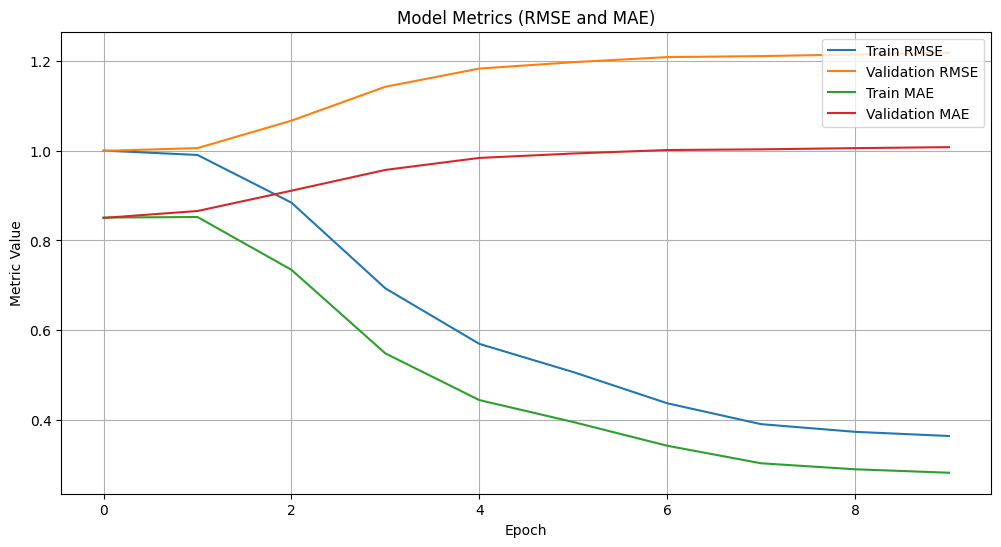

In [20]:
# Visualisasi model metrik
plt.figure(figsize=(12, 6))
plt.plot(history.history['rmse'], label='Train RMSE')
plt.plot(history.history['val_rmse'], label='Validation RMSE')
plt.plot(history.history['mae'], label='Train MAE')
plt.plot(history.history['val_mae'], label='Validation MAE')

plt.title('Model Metrics (RMSE and MAE)')
plt.ylabel('Metric Value')
plt.xlabel('Epoch')
plt.legend(loc='upper right')
plt.grid(True)
plt.show()

In [21]:
# Fungsi untuk memberikan rekomendasi buku
def get_book_recommendations(model, user_id, merged_df, user_to_index, book_to_index, train_mean, train_std, top_k=5):
    # Cek apakah user ada dalam dataset
    if user_id not in user_to_index:
        print(f"User {user_id} tidak ditemukan!")
        return None

    # Ambil index user
    user_idx = user_to_index[user_id]
    # Cari buku yang sudah dibaca user
    user_books = merged_df[merged_df['userId'] == user_id]['bookIndex'].values

    # Ambil semua buku
    all_books = list(book_to_index.keys())

    # Filter buku yang belum dibaca
    unread_books = []
    for book in all_books:
        if book not in user_books:
            unread_books.append(book)

    if len(unread_books) == 0:
        print("Tidak ada buku baru untuk direkomendasikan!")
        return None

    # Buat array untuk prediksi
    user_array = []
    book_array = []

    for book in unread_books:
        user_array.append(user_idx)
        book_array.append(book_to_index[book])

    user_array = np.array(user_array)
    book_array = np.array(book_array)
    # Prediksi rating
    predictions_norm = model.predict(user_array, book_array)
    predictions = predictions_norm * train_std + train_mean
    # Buat list rekomendasi
    recommendations = []
    for i, book in enumerate(unread_books):
        score = float(predictions[i])  # Convert ke float
        # Cari nama buku
        book_name = merged_df[merged_df['bookIndex'] == book]['Book Name'].iloc[0]
        recommendations.append({
            'bookIndex': book,
            'bookName': book_name,
            'predicted_score': score
        })
    # Urutkan berdasarkan score tertinggi
    recommendations = sorted(recommendations, key=lambda x: x['predicted_score'], reverse=True)
    return recommendations[:top_k]

# Pilih 3 user random sebagai sampel
print("="*50)
print("REKOMENDASI BUKU")
print("="*50)
sample_users = list(user_to_index.keys())[:3]
for i, user in enumerate(sample_users, 1):
    print(f"\n{i}. USER {user}")
    print("-"*30)

    # Lihat history rating user
    user_history = merged_df[merged_df['userId'] == user]
    print(f"User ini pernah rating {len(user_history)} buku")

    # Tampilkan 3 buku dengan rating tertinggi
    top_books = user_history.sort_values('score', ascending=False).head(3)
    print("Buku favorit user:")
    for _, row in top_books.iterrows():
        print(f"  - {row['Book Name'][:40]} (Rating: {row['score']})")

    # Hasil rekomendasi
    recommendations = get_book_recommendations(cf_model, user, merged_df, user_to_index, book_to_index, train_mean, train_std)
    if recommendations:
        print("\nRekomendasi buku:")
        for j, rec in enumerate(recommendations, 1):
            print(f"  {j}. {rec['bookName'][:40]} (Score: {rec['predicted_score']:.2f})")
    else:
        print("Tidak bisa memberikan rekomendasi")
    print()
print("Selesai!")

REKOMENDASI BUKU

1. USER 65674
------------------------------
User ini pernah rating 7 buku
Buku favorit user:
  - Camp Jupiter Classified: A Probatio's Jo (Rating: 5)
  - Every Missing Piece (Rating: 4)
  - Eden Mine (Rating: 3)
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


<ipython-input-21-6b9706dfed96>:42: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  score = float(predictions[i])  # Convert ke float



Rekomendasi buku:
  1. Lessons in Chemistry (Score: 3.03)
  2. Viviana Valentine Gets Her Man (Girl Fri (Score: 3.03)
  3. Birds: Photographs (Score: 3.03)
  4. Difficult Women: A History of Feminism i (Score: 3.03)
  5. My Dark Vanessa (Score: 3.02)


2. USER 45825
------------------------------
User ini pernah rating 9 buku
Buku favorit user:
  - Boyfriend Material (London Calling, #1) (Rating: 5)
  - All's Well (Rating: 4)
  - Don't Burn This Country: Surviving and T (Rating: 3)
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step

Rekomendasi buku:
  1. Lessons in Chemistry (Score: 3.04)
  2. Viviana Valentine Gets Her Man (Girl Fri (Score: 3.03)
  3. Difficult Women: A History of Feminism i (Score: 3.03)
  4. My Dark Vanessa (Score: 3.03)
  5. The Book of Lost Friends (Score: 3.03)


3. USER 22291
------------------------------
User ini pernah rating 6 buku
Buku favorit user:
  - The Psychology of Money (Rating: 4)
  - The Unforgettable Logan Foster (Logan Fo (Rating: 3)
  - Dinosaurs: 10 Thin

Berdasarkan hasil visualisasi metrik dan evaluasi model, terlihat bahwa pola pembelajaran yang diamati sebelumnya terkonfirmasi melalui grafik yang menunjukkan **Train RMSE urun konsisten dari 1.0 menjadi 0.37** dan **Train MAE dari 0.85 menjadi 0.28**, sesuai dengan penurunan loss yang terjadi selama 10 epoch pelatihan. Namun, grafik juga mengungkap aspek penting yang tidak terlihat dari log pelatihan sebelumnya, yaitu **Validation RMSE** dan **MAE** yang justru meningkat dari **1.0** menjadi sekitar **1.2** dan **1.0**, mengindikasikan terjadinya **overfitting** yang semakin memburuk seiring berjalannya epoch. Hasil evaluasi juga menunjukkan bahwa meskipun terdapat **overfitting**, model tetap mampu menghasilkan rekomendasi yang berkualitas dengan prediksi rating yang realistis dalam rentang **3.04-3.06**, menunjukkan bahwa model tidak kehilangan kemampuan generalisasinya secara drastis. Analisis rating historis pengguna menunjukkan pola yang menarik, dimana **USER 65674** memiliki riwayat rating tertinggi 5.0 untuk **Camp Jupiter Classified**, **USER 45825** juga memberikan rating maksimal 5.0 untuk **Boyfriend Material**, dan **USER 22291** memberikan rating 4.0 yang menunjukkan preferensi yang cukup tinggi. Skor prediksi yang konsisten di sekitar **3.0-3.1** untuk semua rekomendasi mengindikasikan bahwa model cenderung konservatif dalam prediksi rating, tidak berani memprediksi rating tinggi seperti 4-5 yang pernah diberikan pengguna sebelumnya, namun tetap memberikan prediksi yang reasonable. Secara keseluruhan, meskipun grafik menunjukkan adanya overfitting, hasil evaluasi praktis membuktikan bahwa model cukup efektif dalam memberikan prediksi rating yang stabil.